
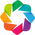

In [23]:
import loren_frank_data_processing as lfdp
import replay_classification as replay
import ripple_detection as ripple
import matplotlib.pyplot as plt
import holoviews as hv
import inspect
import os
import pandas as pd
import numpy as np
from ipywidgets import FloatProgress
from IPython.display import display
import functools
hv.notebook_extension('bokeh')
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
animal_id = 'JZ1'
day, epoch = [1, 2]
ripple_area = 'ca1'
mu_areas = ['ca1', 'mec']
animals = {
    'JZ1': lfdp.Animal(short_name='JZ1', directory='../Raw-Data/JZ1')}
date = 20161114
epoch_index = ('JZ1', 1, 2)
areas = ['ca1']
mark_variables = ['channel_1_max', 'channel_2_max', 'channel_3_max',
                  'channel_4_max']

In [83]:
# os.system('subl {0}'.format(lfdp.__file__))
# os.system('subl ~/anaconda3/envs/Roumis_2018/lib/python3.6/site-packages/loren_frank_data_processing/tetrodes.py')

[autoreload of src.data_iterators failed: Traceback (most recent call last):
  File "/home/droumis/anaconda3/envs/Roumis_2018/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/home/droumis/anaconda3/envs/Roumis_2018/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/home/droumis/anaconda3/envs/Roumis_2018/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/droumis/anaconda3/envs/Roumis_2018/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._boot

0

In [3]:
from src.parameters import ANIMALS
epoch_info = lfdp.make_epochs_dataframe(ANIMALS)

In [11]:
ntrode_df = lfdp.make_tetrode_dataframe(animals)
ntrode_keys = ntrode_df.xs(epoch_index, drop_level=False).index.values
ntrodes = ntrode_df.xs(
    epoch_index, drop_level=False
).index.get_level_values('tetrode_number').tolist()

# mec_ntrode_df = ntrode_df.xs(
#     epoch_index, drop_level=False
# ).query('area == "mec"')

ca1_ntrode_df = ntrode_df.xs(
    epoch_index, drop_level=False
).query('area == "ca1"')

In [5]:
position_variables = ['linear_distance', 'trajectory_direction', 'speed']
position_df = lfdp.get_interpolated_position_dataframe(epoch_index, animals)
# add the time index values as another col
position_df['time'] = position_df.index

In [6]:
f = FloatProgress(min=0, max=ntrode_keys.shape[0])
f.value = 0
display(f)
mu_df = []
for key_num, ntrode_key in enumerate(ntrode_keys):
    mu_df.append(lfdp.get_multiunit_indicator_dataframe(ntrode_key, animals))
    f.value += 1

FloatProgress(value=0.0, max=30.0)

# per minute chunk marks

In [7]:
%autoreload 2
from src.data_iterators import minute_linspaced_epoch_times, chunk_mark_timeseries

In [8]:
ntrode_key = ('JZ1', 1, 2, 16)

In [235]:
linspaced_times = minute_linspaced_epoch_times(animals, epoch_index)

In [248]:
mark_linspace_chunks = chunk_mark_timeseries(mark_times, ntrodes, linspaced_times, position_df,
                          resample_time='1ms')

In [250]:
mark_linspace_chunks.head()

,segment_ID,segment_type,area,start_time,end_time,marks,ntrodes,linear_position,times
0,0,NaN,NaN,00:28:00.085200,00:29:00.085200,channel_1_max channel_2_m...,NaN,labeled_segments from_well to...,NaN
1,1,NaN,NaN,00:29:00.085200,00:30:00.085200,channel_1_max channel_2_m...,NaN,labeled_segments from_well to...,NaN
2,2,NaN,NaN,00:30:00.085200,00:31:00.085200,channel_1_max channel_2_m...,NaN,labeled_segments from_well to...,NaN
3,3,NaN,NaN,00:31:00.085200,00:32:00.085200,channel_1_max channel_2_m...,NaN,labeled_segments from_well to...,NaN
4,4,NaN,NaN,00:32:00.085200,00:33:00.085200,channel_1_max channel_2_m...,NaN,labeled_segments from_well to...,NaN


# Ripple Marks

In [12]:
hippocampus_lfps = lfdp.get_LFPs(ca1_ntrode_df.index, animals)
time = hippocampus_lfps.index
sampling_frequency = 1500
ripple_times = ripple.Kay_ripple_detector(
    time, hippocampus_lfps.values, position_df.speed.values, sampling_frequency,
    minimum_duration=pd.Timedelta(milliseconds=15), zscore_threshold=4)

In [724]:
def get_ntrode_spikes_dmap_local(event_times, spike_times, ntrode=1):
    import pandas as pd
    '''per ntrode, event-triggered spike raster as Holoviews DynamicMap

    Parameters
    ----------
    ntrode_number : int, default 0 for initialization
    ntrodes : list of ints
    event_times : pd.DataFrame, columns=['start_time', 'end_time']
    spike_times : pd.DataFrame, index=timedelta labeled 'time'
    window : float

    Returns
    -------
    Spikes : Holoviews Spikes element

    '''
    events = np.arange(1,event_times.shape[0]+1)
    window_spikes = pd.DataFrame(pd.concat([(spike_times[ntrode].dropna()[(rv.start_time-timedelta(seconds=.5)):(rv.start_time+timedelta(seconds=.5))].reset_index()['time'] - rv.start_time).dt.total_seconds()
                 for irip, rv in event_times.iterrows()
                 ], keys=events, names=['event_number'])).reset_index()

    Spikes = {}
    for irip, ripvals in event_times.iterrows():
        Spikes[irip] = hv.Spikes(window_spikes[window_spikes.event_number == irip].time,
         kdims = 'time',  group = 'SWR-trig_multi-unit').opts(plot = dict(position = irip))

    Spikes_dmap = hv.NdOverlay(overlays=Spikes, kdims=['event_number']).opts(plot = dict(yticks = events))

    return Spikes_dmap

In [725]:
func_local = functools.partial(get_ntrode_spikes_dmap_local, event_times, mu_df)
spikes_dmap_local = hv.DynamicMap(func_local, kdims=['ntrode']).redim.range(ntrode=((1,30)))

In [726]:
%%opts Spikes {+framewise} [height=400 width=600] 
# bgcolor='white' spike_length=10] (line_width=1)
spikes_dmap_local

:DynamicMap   [ntrode]

In [69]:
%autoreload 2
import src.visualization as viz
from src.data_iterators import get_ntrode_event_spikes

In [40]:
window_spikes = get_ntrode_event_spikes(ripple_times, mu_df, ntrodes, window=.4)

KeyboardInterrupt: 

In [32]:
dict_spec = {'Spikes':{'style':dict(color='grey')}, 
             'Spikes.multiunit':{'style':dict(color='grey')}, 
             'Spikes.multiunit.ca1': {'style':dict(color='blue')}, # 'plot':dict(interpolation='steps-mid')},
             'Spikes.multiunit.mec': {'style':dict(color='purple')}}

In [70]:
dmapfunc = functools.partial(viz.get_ntrode_spikes_dmap,
                             ripple_times,
                             window_spikes,
                             epoch_index,
                             ntrode_df
                            )

In [71]:
spikes_dmap = hv.DynamicMap(dmapfunc, kdims=['ntrode']).redim.range(ntrode=((1,30)))#.opts(dict_spec)

In [ ]:
raster_curve = hv.Curve(spikes_dmap)

In [72]:
%%opts Spikes {+framewise} [height=400 width=600 bgcolor='white' spike_length=1] (line_width=1 alpha=.2)
# %%opts Polygons {+framewise} (color='white' linewidth=10 alpha=.3)

spikes_dmap #* event_bounds

:DynamicMap   [ntrode]